## Imports 


In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
# Import matplotlib for visualization
import matplotlib.pyplot as plt
import numpy as np
# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldnt' be lower than 0.11
print(f'PyTorch version: {torch.__version__}\ntorchvision version: { torchvision.__version__}')

from collections import Counter
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import random
from collections import defaultdict
import pandas as pd

PyTorch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


### Load data

Create folder for data

In [ ]:
!mkdir data

Load data from pytorch dataset and extract in data folder, images tranform to tensor.

In [2]:
all_data = datasets.LFWPeople(
    root="/content/data", # where to download data to?
    split = "10fold", # get all data
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None, # you can transform labels as well
    download=True # download data if it doesn't exist on disk
)

Files already downloaded and verified


Looks what's inside dataset

In [3]:
all_data


Dataset LFWPeople
    Number of datapoints: 13233
    Root location: /content/data/lfw-py
    Alignment: funneled
    Split: 10fold
    Classes (identities): 5749
    StandardTransform
Transform: ToTensor()

Load all dataset names

In [3]:
# Open the text file containing the names of the people in the training dataset
with open("/content/data/lfw-py/lfw-names.txt") as f:
    # Read the contents of the file and split it into a list of names
    names = [name.split("\t")[0] for name in f.read().splitlines()]

## Check, how data looks


Look at random value from dataset. Should be (tensor [ ], int)

In [4]:
image, label = all_data[0]
image, label

(tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.6510, 0.6510, 0.0000],
          [0.0078, 0.0078, 0.0039,  ..., 0.6549, 0.6431, 0.6549],
          [0.0039, 0.0039, 0.0118,  ..., 0.6549, 0.6667, 0.6588],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6784, 0.6902, 0.0157],
          [0.0039, 0.0039, 0.0000,  ..., 0.6941, 0.6824, 0.6941],
          [0.0000, 0.0000, 0.0078,  ..., 0.6980, 0.7098, 0.7020],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6510, 0.6588, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.6627, 0.6510, 0.6627],
          [0.0000, 0.0000, 0.0000,  ...,

Let's look at top 10 labels which have the most images per label

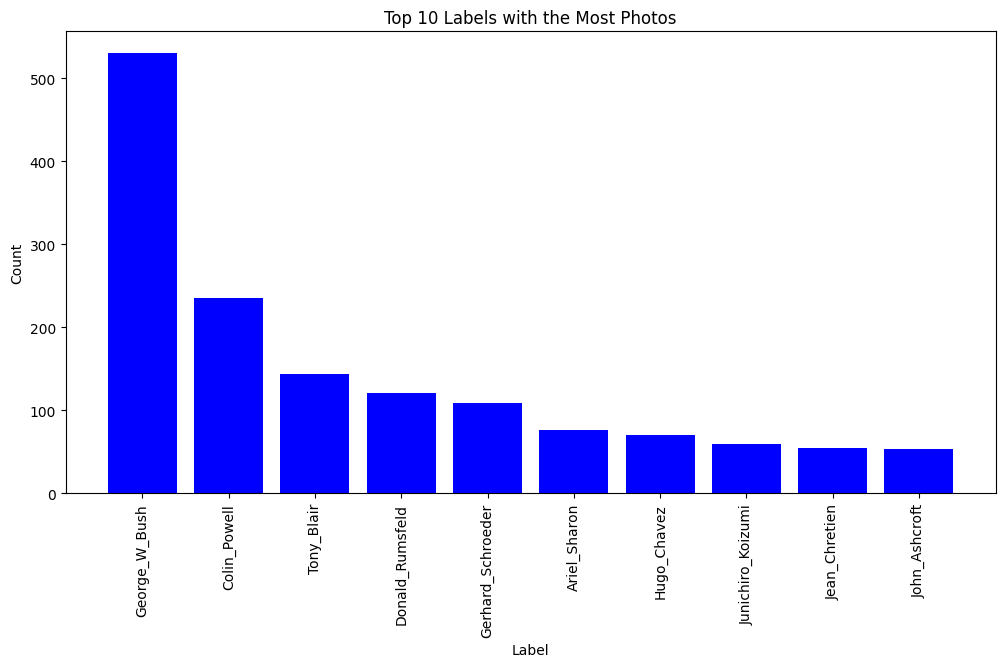

In [5]:
# Get the label counts
label_counts = Counter(all_data.targets)

# Sort the labels by count
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 labels with the most and least number of photos
top_10_most = sorted_labels[:10]
top_10_least = sorted_labels[-10:]

# Extract the label names and counts for plotting
most_labels = [names[idx] for idx, count in top_10_most]
most_counts = [count for idx, count in top_10_most]
least_labels = [names[idx] for idx, count in top_10_least]
least_counts = [count for idx, count in top_10_least]

# Create a bar chart for the top 10 labels with the most photos
plt.figure(figsize=(12, 6))
plt.bar(most_labels, most_counts, color='b')
plt.title('Top 10 Labels with the Most Photos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



From the graph we can see that we have labels which have much more images than others labels. In data feature engineering we fix that labels which have more than 50 images.

Look at top 10 labels which have the least images per label

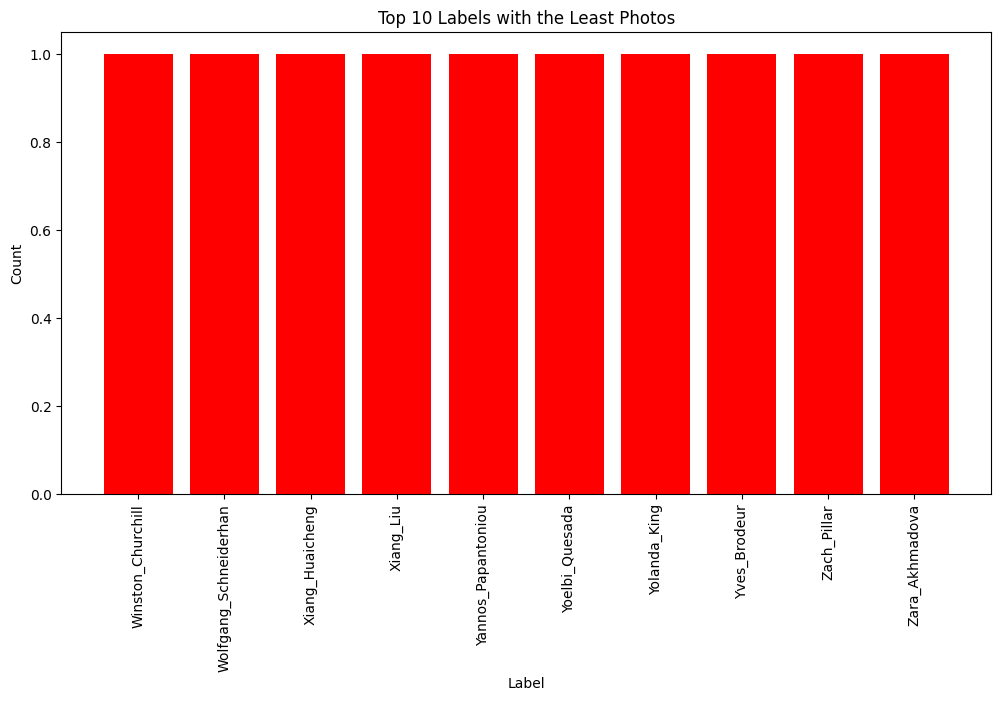

In [6]:
# Create a bar chart for the top 10 labels with the least photos
plt.figure(figsize=(12, 6))
plt.bar(least_labels, least_counts, color='r')
plt.title('Top 10 Labels with the Least Photos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

As we see all 10 labels have 1 image, let's see how much labels have less than 2 images

In [37]:
# Get the label counts
label_counts = torch.bincount(torch.tensor(all_data.targets))

# Count the number of labels with less than 2 images
num_labels_less_than_2 = (label_counts < 2).sum().item()

print(f"Number of labels with less than 2 images: {num_labels_less_than_2}")

Number of labels with less than 2 images: 4069


As we see most of labels have less than 2 images per label, that not good for our model training.

We need to find our outlayers, as we see from graphs, this dataset have a lot of names which have less than 2 photos, so let's create function which check this dataset outlayers.

In [33]:
def check_outliers(_dataset, percentile=90):
    images = _dataset.data
    labels = _dataset.targets
    label_counts = {}
    for label in labels:
        label_counts[label] = label_counts.get(label, 0) + 1

    counts = np.array(list(label_counts.values()))
    threshold = np.percentile(counts, percentile)

    outliers_above = np.sum(counts > threshold)
    outliers_below = np.sum(counts < threshold)

    return threshold, outliers_above, outliers_below

In [34]:
threshold, outliers_above, outliers_below = check_outliers(all_data, percentile=90)
print("Threshold for outlier detection:", threshold)
print("Labels with more images than threshold:", outliers_above)
print("Labels with fewer images than threshold:", outliers_below)

Threshold for outlier detection: 4.0
Labels with more images than threshold: 423
Labels with fewer images than threshold: 5139


As we see 90 procent labels have less than 4 images per label, this is not so good for our model training so i specify choose that my dataset should have something around 40-55 images per label.

## Data feature engineering

Even we lost most labels i choose to delete all images and labels who have less than 10 images per label

In [38]:
# Create a list of identity counts
identity_counts = [list(all_data.targets).count(i) for i in range(len(set(all_data.targets)))]

# Iterate through the dataset in reverse order and remove the samples with less than 10 images
for i in reversed(range(len(all_data))):
    if identity_counts[all_data.targets[i]] < 10:
        all_data.data.pop(i)
        all_data.targets.pop(i)
    


# Print the number of samples and identities in the modified dataset
print("Number of images:", len(all_data))
print("Classes (identities):", len(set(all_data.targets)))

Number of images: 4324
Classes (identities): 158


Now i need to fix all labels which have more than 50 images/label 

In [39]:
for _ in range(0,6):
  # Convert the list of targets to a Tensor
  targets = torch.tensor(all_data.targets)
  # Count the number of images per label
  counts = torch.bincount(targets)

  # Iterate through the dataset and remove images from labels with more than 50 images

  for i, (image, label) in enumerate(all_data):
      if counts[label] > 50:
          if random.random() > 50 / counts[label]:
              # Remove the image and update the counts
              all_data.data.pop(i)
              all_data.targets.pop(i)
              counts[label] -= 1

# Print the number of samples and identities in the modified dataset
print("Number of datapoints:", len(all_data))
print("Classes (identities):", len(set(all_data.targets)))

Number of datapoints: 3372
Classes (identities): 158


Looks at the same graphs after first updates

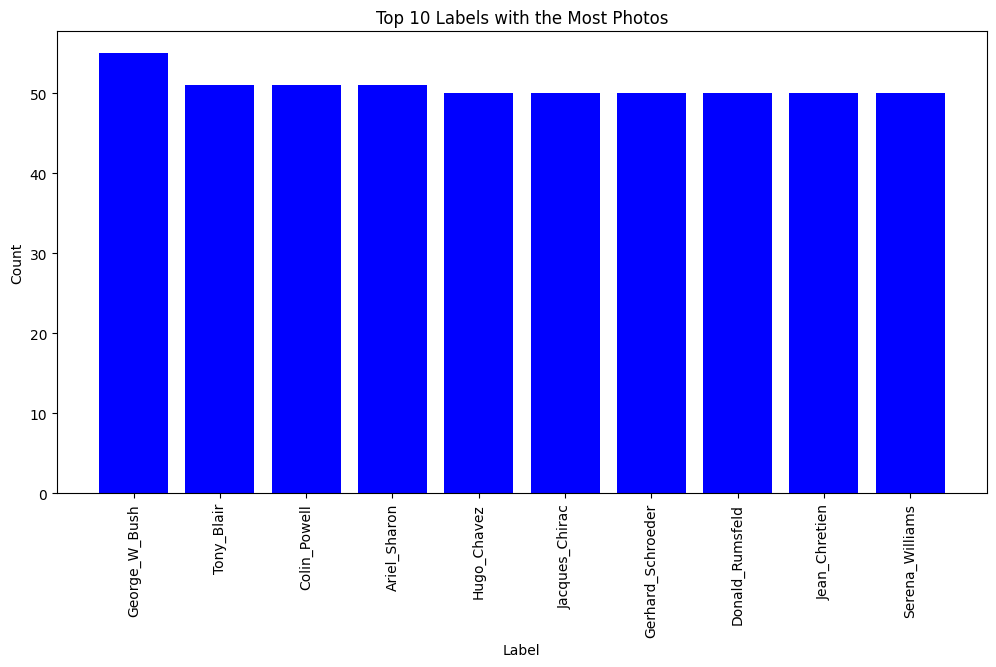

In [40]:
label_counts = Counter(all_data.targets)
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
top_10_most = sorted_labels[:10]
top_10_least = sorted_labels[-10:]
most_labels = [names[idx] for idx, count in top_10_most]
most_counts = [count for idx, count in top_10_most]
least_labels = [names[idx] for idx, count in top_10_least]
least_counts = [count for idx, count in top_10_least]

# Create a bar chart for the top 10 labels with the most photos
plt.figure(figsize=(12, 6))
plt.bar(most_labels, most_counts, color='b')
plt.title('Top 10 Labels with the Most Photos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

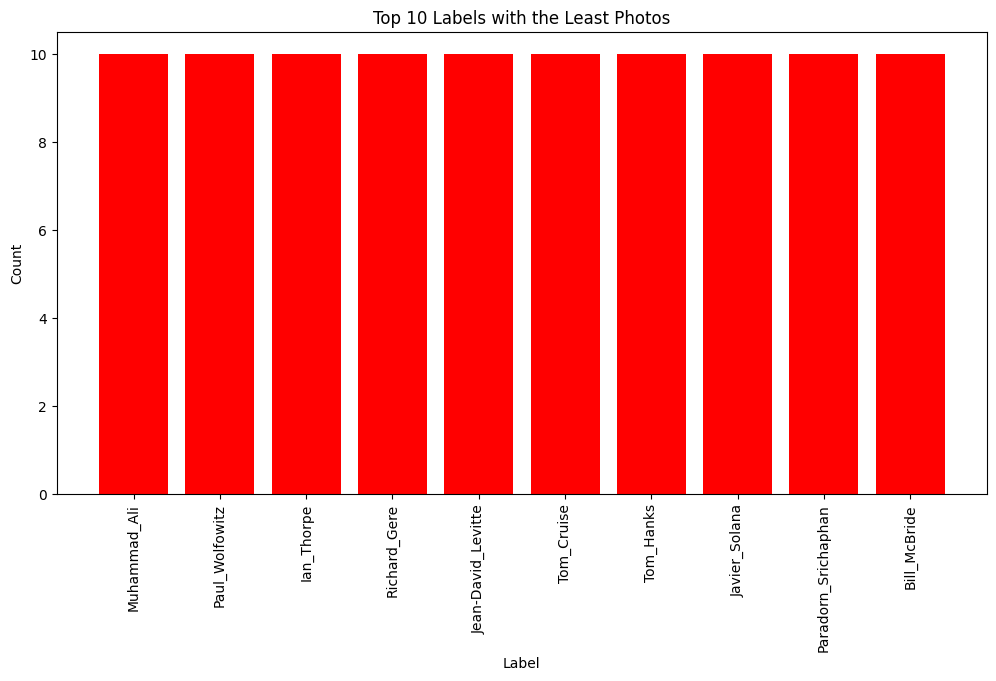

In [41]:
# Create a bar chart for the top 10 labels with the least photos
plt.figure(figsize=(12, 6))
plt.bar(least_labels, least_counts, color='r')
plt.title('Top 10 Labels with the Least Photos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

After fix value above 50 and remove those who got less than 10, we need to check how much labels have less than 40 images per label, because as i said earlier i want that my dataset need to have 40-55 images per label

In [43]:
# Create a defaultdict to keep track of the number of images per label
num_images_per_label = defaultdict(int)

# Iterate through the dataset and count the number of images per label
for i in range(len(all_data)):
    image, label = all_data[i]
    num_images_per_label[label] += 1

# Count the number of labels with less than 40 images
count = 0
for label in num_images_per_label:
    if num_images_per_label[label] < 40:
        count += 1

print("Number of labels with less than 40 images:", count,"of",len(set(all_data.targets)))

Number of labels with less than 40 images: 139 of 158


As we can see more than 88 procent labels have less images than 40. So now we fix it with augmentation techniques.

In [44]:
import torchvision.transforms.functional as F

class GaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

This cell take long run ( for me its took around 13min). This cell find labels which have less than 40 images per label, then took one of label and making new images of those that already this label have. New images is created after using 1 of 5 random method.

In [45]:
# Create a dictionary to store the counts for each label
label_counts = {}

# Loop through the dataset and count the number of images for each label
for i in range(len(all_data)):
    _, label = all_data[i]
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Find all labels with less than 40 images
labels_to_augment = [label for label, count in label_counts.items() if count < 40]

# Define the transforms to use for the image augmentation
rotation_transform = transforms.RandomRotation(degrees=15)
horizontal_flip_transform = transforms.RandomHorizontalFlip()
color_jitter_transform = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
resize_crop_transform = transforms.RandomResizedCrop(size=(250, 250), scale=(0.8, 1.0))
gaussian_noise_transform = transforms.Lambda(lambda x: GaussianNoise(mean=0, std=0.1)(x))

# Create a new list to store all the data, including augmented images
alll_data = list(all_data)

# Loop through the labels to augment
for label in labels_to_augment:
    # Create a list of indices for all images with the current label
    label_indices = [i for i in range(len(all_data)) if all_data[i][1] == label]
    # Loop until the label has 40 images
    while label_counts[label] < 40:
        # Choose a random image index to augment
        image_index = label_indices[torch.randint(len(label_indices), size=(1,)).item()]
        # Load the image and apply a random augmentation
        image, _ = all_data[image_index]
        transform_choice = torch.randint(5, size=(1,)).item()
        if transform_choice == 0:
            image = rotation_transform(image)
        elif transform_choice == 1:
            image = horizontal_flip_transform(image)
        elif transform_choice == 2:
            image = color_jitter_transform(image)
        elif transform_choice == 3:
            image = resize_crop_transform(image)
        elif transform_choice == 4:
            image = gaussian_noise_transform(image)
        # Add the augmented image to the dataset
        alll_data.append((image, label))
        # Update the label count
        label_counts[label] += 1
        
# Separate the images and labels into separate lists
images = [x[0] for x in alll_data]
labels = [x[1] for x in alll_data]




/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


After we make new images, everything i add to lists, so now i create new dataset from these lists

In [46]:
# Create a PyTorch dataset from the lists
class MyDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

new_dataset = MyDataset(images, labels)

Checking that new dataset have same values as original ( tensor, int)

In [47]:
new_dataset[0]

(tensor([[[0.0078, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4706, 0.4784, 0.4863,  ..., 0.0000, 0.0000, 0.0000],
          [0.4784, 0.4863, 0.5020,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3333, 0.3294, 0.2784,  ..., 0.0000, 0.0000, 0.0000],
          [0.2980, 0.2667, 0.2275,  ..., 0.0000, 0.0000, 0.0000],
          [0.2667, 0.2353, 0.1961,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0078, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.4706, 0.4784, 0.4902,  ..., 0.0000, 0.0000, 0.0000],
          [0.4784, 0.4824, 0.5059,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2196, 0.2588, 0.2824,  ..., 0.0000, 0.0000, 0.0000],
          [0.2745, 0.2824, 0.2980,  ..., 0.0000, 0.0000, 0.0000],
          [0.2784, 0.2784, 0.2902,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4392, 0.4471, 0.4667,  ..., 0.0000, 0.0000, 0.0000],
          [0.4471, 0.4627, 0.4863,  ...,

Let's look how much identities and images we have. Before augmentation we have 3372 images and 158 identities

In [49]:
print("Classes (identities):", len(set(new_dataset.labels)))
print("Images (all images):",len(new_dataset))

Classes (identities): 158
Images (all images): 6475


That's great! Our dataset increase double.

Now last time before starting work with deep learning model, let's check the graphs.

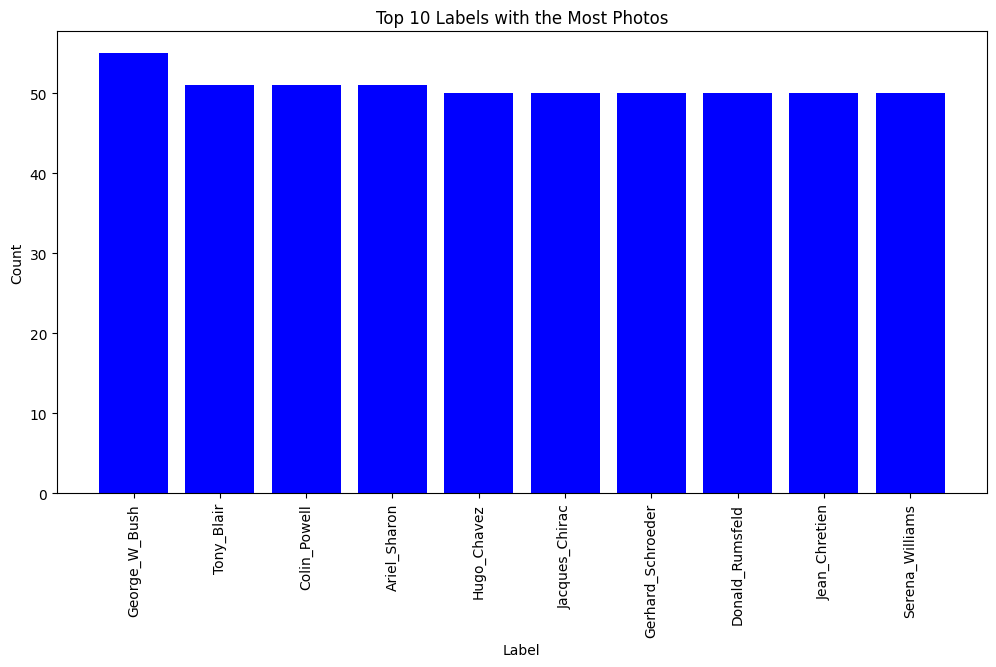

In [50]:
label_counts = Counter(new_dataset.labels)
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
top_10_most = sorted_labels[:10]
top_10_least = sorted_labels[-10:]
most_labels = [names[idx] for idx, count in top_10_most]
most_counts = [count for idx, count in top_10_most]
least_labels = [names[idx] for idx, count in top_10_least]
least_counts = [count for idx, count in top_10_least]

# Create a bar chart for the top 10 labels with the most photos
plt.figure(figsize=(12, 6))
plt.bar(most_labels, most_counts, color='b')
plt.title('Top 10 Labels with the Most Photos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

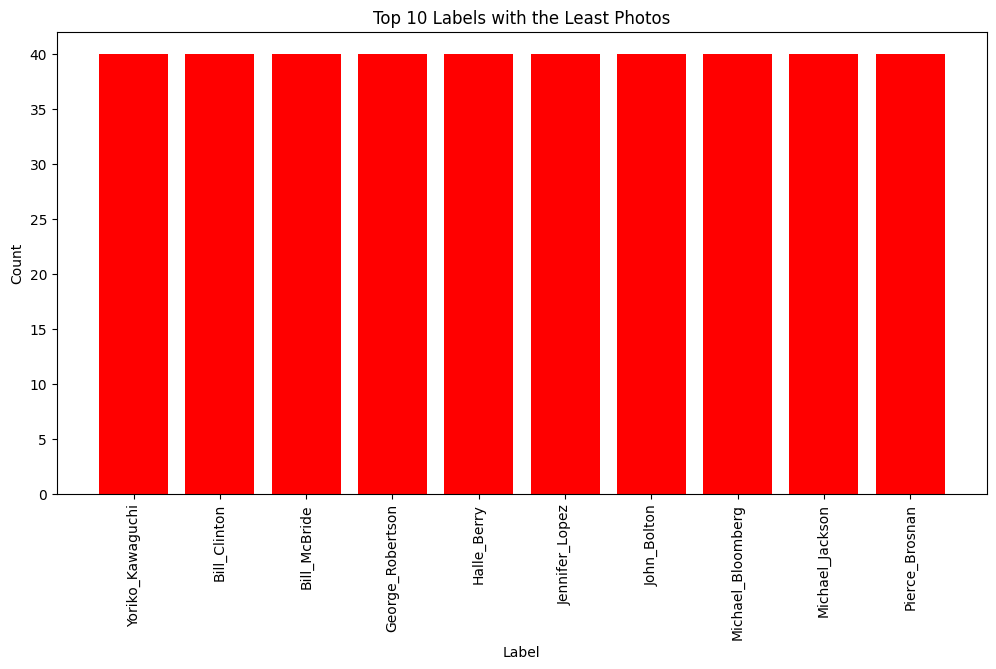

In [52]:
# Create a bar chart for the top 10 labels with the least photos
plt.figure(figsize=(12, 6))
plt.bar(least_labels, least_counts, color='r')
plt.title('Top 10 Labels with the Least Photos')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

After our data feature engineering we lost most of labels. When we load the label names we upload list of all names and because i wont train model with all names, i want train it just with those 158. So now we need to encode and decode our labels, because we will need to know which label from original dataset is in our.

In [53]:
# Encode the targets
le = LabelEncoder()
new_dataset.labels = le.fit_transform(new_dataset.labels)

# Check the encoded targets
print("Encoded targets:", new_dataset.labels)

Encoded targets: [  8   8   8 ... 120 120 120]


In [54]:
# Decode the targets
decoded_targets = le.inverse_transform(new_dataset.labels)
print("Decoded targets:", decoded_targets)

Decoded targets: [ 317  317  317 ... 4403 4403 4403]


Now we can split data, i choose to split in 80procent of training and 20 of test.

In [55]:
import random
from torch.utils.data import Subset
# Split the dataset into training and test sets
n_samples = len(new_dataset)
train_size = int(0.8 * n_samples)

test_size = n_samples - train_size

indices = list(range(n_samples))
random.shuffle(indices)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data = Subset(new_dataset, train_indices)
test_data = Subset(new_dataset, test_indices)

# Print the number of samples and identities in each set
print("Number of datapoints in the training set:", len(train_data))
print("Number of datapoints in the test set:", len(test_data))
print("Classes (identities) in the training set:", len(set(train_data.dataset.labels)))
print("Classes (identities) in the test set:", len(set(test_data.dataset.labels)))

Number of datapoints in the training set: 5180
Number of datapoints in the test set: 1295
Classes (identities) in the training set: 158
Classes (identities) in the test set: 158


Now look at random photo, and make title as name

Image shape: torch.Size([3, 250, 250])


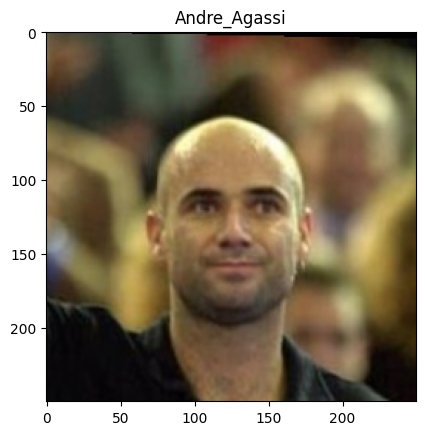

In [56]:
image, label = new_dataset[450]
print(f'Image shape: {image.shape}')
plt.imshow(image.permute(1,2,0)) # image shape is [3, 250, 250] (colour_channel, height, width)
plt.title(names[le.inverse_transform([label])[0]]);

Okay, we see image and title, now i want to see more image to be sure that images and names is okay

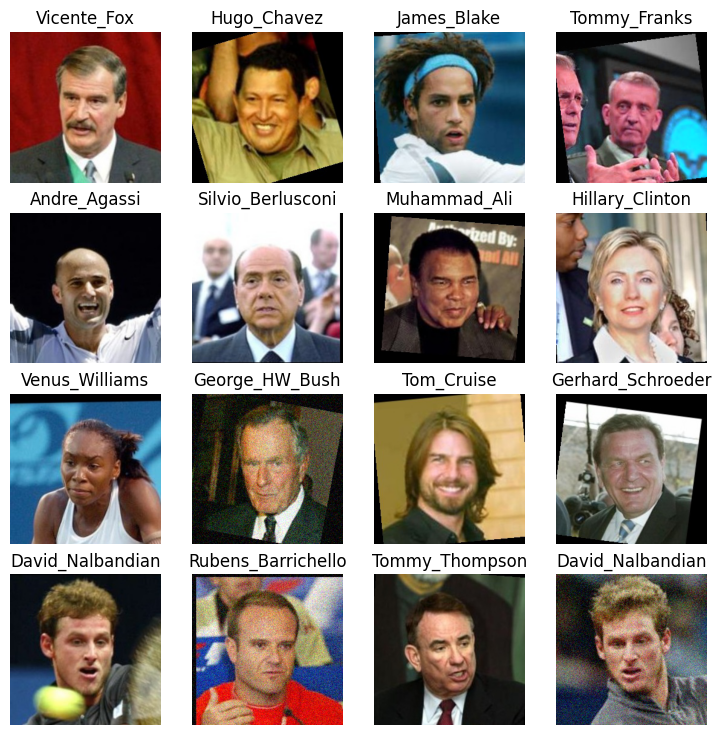

In [57]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows * cols +1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1,2,0))
  plt.title(names[le.inverse_transform([label])[0]])
  plt.axis(False);

Perfect, all images are visible and names are correct. We can see some images with modification, thats good.

## Data loader

Preprade dataset with dataloarder, one of hyperparameter (batch size is 32)

In [58]:
# Setup the batch size hyperparamete
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
      batch_size = BATCH_SIZE, # how many sample per batch?
      shuffle = True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data, 
      batch_size = BATCH_SIZE, 
      shuffle = False # don't necessarily have shuffle the testing data
)

# Let's check what we've created
print(f'DataLoaders: {train_dataloader, test_dataloader}')
print(f'Length of train dataloder: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of test dataloder: {len(test_dataloader)} batches of {BATCH_SIZE}')

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f5111d9cf10>, <torch.utils.data.dataloader.DataLoader object at 0x7f5111d9cbb0>)
Length of train dataloder: 162 batches of 32
Length of test dataloder: 41 batches of 32


Check out what's inside the training dataloader

In [60]:

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 250, 250]), torch.Size([32]))

Show a sample, to see that nothing changes

Image size: torch.Size([3, 250, 250])
Label: 86, label size: torch.Size([])


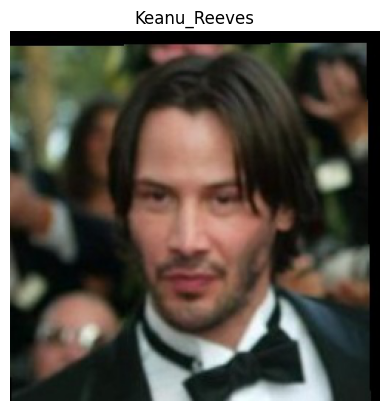

In [61]:

torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.permute(1,2,0))
plt.title(names[le.inverse_transform([label])[0]])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

Set our device to cuda if it is posible

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Create function where we can pass the model and some data for it to predict on.

In [63]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,device: torch.device = device):
   
    loss, acc = 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device) 

            # Make predictions with the model
            y_pred = model(images)
            
            log_probabilities = model(images)
            loss += criterion(log_probabilities, labels).item()

            probabilites = torch.exp(log_probabilities)
            top_prob, top_class = probabilites.topk(1, dim=1)
            predictions = top_class == labels.view(*top_class.shape)
            acc += torch.mean(predictions.type(torch.FloatTensor))
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss,
            "model_acc": acc}

Setup timer to calcute time of training

In [64]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

First i try CNN network, its basic deep learning model per image clasification

Define network

In [66]:
class CNNnetwork(nn.Module):
  def __init__(self):
    super(CNNnetwork, self).__init__()
    # Convolutional Neural Network layer
    self.convolutional_neural_network_layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        
        nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        
        nn.Conv2d(in_channels=24, out_channels=36, kernel_size=4, padding=1, stride=1),
        nn.ReLU(),
          
        nn.Conv2d(in_channels=36, out_channels=36, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    # Linear Layer
    self.linear_layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=36*62*62, out_features=len(set(new_dataset.labels)))
    )

  # Defining forward pass
  def forward(self, x):
    x = self.convolutional_neural_network_layers(x)
    # After we get output of our convolutional layer we must flatten it 
    x = x.view(x.size(0), -1)
    # Then pass it through the linear layer
    x = self.linear_layers(x)
    # The softmax function returns the prob likelihood of getting the input image.
    # We will see a graphical demonstration below
    x = F.log_softmax(x, dim=1)
    return x

Load model 1 to device

In [67]:
modelV1 = CNNnetwork()
modelV1.to(device)
print(modelV1)

CNNnetwork(
  (convolutional_neural_network_layers): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(24, 36, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=138384, out_features=158, bias=True)
  )
)


Setup optimizer and criterion

In [68]:
optimizer = optim.Adam(modelV1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Train model 1

In [69]:
import torch.nn.functional as F
# Measure time
from timeit import default_timer as timer
train_time_start_model_1 = timer()

epochs = 10 # The total number of iteration

train_lossesV1 = []
test_lossesV1 = []

for epoch in range(epochs):
  # model for training
  modelV1.train()
  train_loss = 0

  for idx, (images, labels) in enumerate(train_dataloader):

    # Send these >>> To GPU
    images = images.to(device)
    labels = labels.to(device)

    # Training pass
    optimizer.zero_grad()

    # Forward pass
    output = modelV1(images)
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  else:
    # model for evaluation
    modelV1.eval()
    test_loss = 0
    accuracy = 0

    # Turn off gradients when performing evaluation.
    # As if we don't turn it off, we  will comprise our networks weight entirely
    with torch.no_grad():
      for images, labels in test_dataloader:

        images = images.to(device)
        labels = labels.to(device) 

        log_probabilities = modelV1(images)
        test_loss += criterion(log_probabilities, labels).item()

        probabilites = torch.exp(log_probabilities)
        top_prob, top_class = probabilites.topk(1, dim=1)
        predictions = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(predictions.type(torch.FloatTensor))

      train_lossesV1.append(train_loss/len(train_dataloader))
      test_lossesV1.append(test_loss/len(train_dataloader))

      print("Epoch: {}/{}   ".format(epoch+1, epochs),
            "Training loss: {:.4f}   ".format(train_loss/len(train_dataloader)),
            "Testing loss: {:.4f}   ".format(test_loss/len(train_dataloader)),
            "Test accuracy: {:.4f}   ".format(accuracy/len(test_dataloader)))
train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
                                           end=train_time_end_model_1,
                                           device=device)

Epoch: 1/10    Training loss: 5.1314    Testing loss: 1.2573    Test accuracy: 0.0137   
Epoch: 2/10    Training loss: 3.8611    Testing loss: 0.7580    Test accuracy: 0.4124   
Epoch: 3/10    Training loss: 0.8464    Testing loss: 0.7155    Test accuracy: 0.5343   
Epoch: 4/10    Training loss: 0.1006    Testing loss: 0.9564    Test accuracy: 0.5695   
Epoch: 5/10    Training loss: 0.0040    Testing loss: 1.1354    Test accuracy: 0.5673   
Epoch: 6/10    Training loss: 0.0002    Testing loss: 1.1544    Test accuracy: 0.5704   
Epoch: 7/10    Training loss: 0.0001    Testing loss: 1.1994    Test accuracy: 0.5689   
Epoch: 8/10    Training loss: 0.0000    Testing loss: 1.2303    Test accuracy: 0.5689   
Epoch: 9/10    Training loss: 0.0000    Testing loss: 1.2574    Test accuracy: 0.5673   
Epoch: 10/10    Training loss: 0.0000    Testing loss: 1.2815    Test accuracy: 0.5681   
Train time on cuda: 158.302 seconds


Calculate model 1 results

In [70]:

model_1_results = eval_model(model=modelV1, data_loader=test_dataloader,
    device=device
)
model_1_results

{'model_name': 'CNNnetwork',
 'model_loss': 5.063527845754856,
 'model_acc': tensor(0.5681)}

Create neural network of deepface frame

In [71]:
class DeepFace(nn.Module):
    def __init__(self):
        super(DeepFace, self).__init__()
        
        # 3D alignment network
        self.alignment = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128 * 31 * 31, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        # face recognition network
        self.recognition = nn.Sequential(
            nn.Linear(128, out_features=len(set(new_dataset.labels))),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.alignment(x)
        x = self.recognition(x)
        return x

Load model 2 to device

In [72]:
modelV2 = DeepFace()
modelV2.to(device)
print(modelV2)

DeepFace(
  (alignment): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

Setup optimizer and criterion

In [73]:
optimizer = optim.Adam(modelV2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Train model 2

In [74]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 10 # The total number of iteration

train_lossesV2 = []
test_lossesV2 = []

for epoch in range(epochs):
  # model for training
  modelV2.train()
  train_loss = 0

  for idx, (images, labels) in enumerate(train_dataloader):

    # Send these >>> To GPU
    images = images.to(device)
    labels = labels.to(device)

    # Training pass
    optimizer.zero_grad()

    # Forward pass
    output = modelV2(images)
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  else:
    # model for evaluation
    modelV2.eval()
    test_loss = 0
    accuracy = 0

    # Turn off gradients when performing evaluation.
    # As if we don't turn it off, we  will comprise our networks weight entirely
    with torch.no_grad():
      for images, labels in test_dataloader:

        images = images.to(device)
        labels = labels.to(device) 

        log_probabilities = modelV2(images)
        test_loss += criterion(log_probabilities, labels).item()

        probabilites = torch.exp(log_probabilities)
        top_prob, top_class = probabilites.topk(1, dim=1)
        predictions = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(predictions.type(torch.FloatTensor))

      train_lossesV2.append(train_loss/len(train_dataloader))
      test_lossesV2.append(test_loss/len(train_dataloader))

      print("Epoch: {}/{}   ".format(epoch+1, epochs),
            "Training loss: {:.4f}   ".format(train_loss/len(train_dataloader)),
            "Testing loss: {:.4f}   ".format(test_loss/len(train_dataloader)),
            "Test accuracy: {:.4f}   ".format(accuracy/len(test_dataloader)))
      
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

Epoch: 1/10    Training loss: 5.0523    Testing loss: 1.2768    Test accuracy: 0.0374   
Epoch: 2/10    Training loss: 4.9999    Testing loss: 1.2589    Test accuracy: 0.1094   
Epoch: 3/10    Training loss: 4.9232    Testing loss: 1.2468    Test accuracy: 0.1582   
Epoch: 4/10    Training loss: 4.8388    Testing loss: 1.2326    Test accuracy: 0.2231   
Epoch: 5/10    Training loss: 4.7381    Testing loss: 1.2149    Test accuracy: 0.3092   
Epoch: 6/10    Training loss: 4.6322    Testing loss: 1.1996    Test accuracy: 0.3719   
Epoch: 7/10    Training loss: 4.5261    Testing loss: 1.1752    Test accuracy: 0.4924   
Epoch: 8/10    Training loss: 4.4317    Testing loss: 1.1614    Test accuracy: 0.5298   
Epoch: 9/10    Training loss: 4.3613    Testing loss: 1.1505    Test accuracy: 0.5826   
Epoch: 10/10    Training loss: 4.3126    Testing loss: 1.1442    Test accuracy: 0.6077   
Train time on cuda: 809.927 seconds


Calculate model 2 results

In [75]:

model_2_results = eval_model(model=modelV2, data_loader=test_dataloader,
    device=device
)
model_2_results

{'model_name': 'DeepFace',
 'model_loss': 4.521059443310993,
 'model_acc': tensor(0.6077)}

Build deepID network

In [76]:
class DeepID(nn.Module):
    def __init__(self):
        super(DeepID, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 20, kernel_size=4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(20)
        self.rel1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Second convolutional block
        self.conv2 = nn.Conv2d(20, 40, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(40)
        self.rel2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Third convolutional block
        self.conv3 = nn.Conv2d(40, 60, kernel_size=3, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(60)
        self.rel3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc4 = nn.Linear(60 * 29 * 29, 160)
        self.bn4 = nn.BatchNorm1d(160)
        self.rel4 = nn.ReLU()
        self.fc5 = nn.Linear(160, out_features=len(set(new_dataset.labels)))

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rel1(x)
        x = self.pool1(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rel2(x)
        x = self.pool2(x)

        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.rel3(x)
        x = self.pool3(x)

        # Flatten the output from convolutional blocks
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.rel4(x)

        x = self.fc5(x)

        return x

Load model 3 to device

In [77]:
modelV3 = DeepID()
modelV3.to(device)
print(modelV3)

DeepID(
  (conv1): Conv2d(3, 20, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc4): Linear(in_features=50460, out_features=160, bias=True)
  (bn4): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel4): ReLU()
  (fc5): Linear(in_features=160, out_features=158, bias=True)
)

Setup optimizer and criterion

In [78]:
optimizer = optim.Adam(modelV3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Train model 3

In [79]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_3 = timer()

epochs = 10 # The total number of iteration

train_lossesV3 = []
test_lossesV3 = []

for epoch in range(epochs):
  # model for training
  modelV3.train()
  train_loss = 0

  for idx, (images, labels) in enumerate(train_dataloader):

    # Send these >>> To GPU
    images = images.to(device)
    labels = labels.to(device)

    # Training pass
    optimizer.zero_grad()

    # Forward pass
    output = modelV3(images)
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  else:
    # model for evaluation
    modelV3.eval()
    test_loss = 0
    accuracy = 0

    # Turn off gradients when performing evaluation.
    # As if we don't turn it off, we  will comprise our networks weight entirely
    with torch.no_grad():
      for images, labels in test_dataloader:

        images = images.to(device)
        labels = labels.to(device) 

        log_probabilities = modelV3(images)
        test_loss += criterion(log_probabilities, labels).item()

        probabilites = torch.exp(log_probabilities)
        top_prob, top_class = probabilites.topk(1, dim=1)
        predictions = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(predictions.type(torch.FloatTensor))

      train_lossesV3.append(train_loss/len(train_dataloader))
      test_lossesV3.append(test_loss/len(train_dataloader))

      print("Epoch: {}/{}   ".format(epoch+1, epochs),
            "Training loss: {:.4f}   ".format(train_loss/len(train_dataloader)),
            "Testing loss: {:.4f}   ".format(test_loss/len(train_dataloader)),
            "Test accuracy: {:.4f}   ".format(accuracy/len(test_dataloader)))
      
train_time_end_model_3 = timer()
total_train_time_model_3 = print_train_time(start=train_time_start_model_3,
                                           end=train_time_end_model_3,
                                           device=device)

Epoch: 1/10    Training loss: 4.1079    Testing loss: 0.7613    Test accuracy: 0.5389   
Epoch: 2/10    Training loss: 1.6956    Testing loss: 0.3967    Test accuracy: 0.7502   
Epoch: 3/10    Training loss: 0.3021    Testing loss: 0.2726    Test accuracy: 0.8147   
Epoch: 4/10    Training loss: 0.0396    Testing loss: 0.2329    Test accuracy: 0.8505   
Epoch: 5/10    Training loss: 0.0158    Testing loss: 0.2230    Test accuracy: 0.8481   
Epoch: 6/10    Training loss: 0.0100    Testing loss: 0.2174    Test accuracy: 0.8557   
Epoch: 7/10    Training loss: 0.0071    Testing loss: 0.2142    Test accuracy: 0.8542   
Epoch: 8/10    Training loss: 0.0052    Testing loss: 0.2122    Test accuracy: 0.8519   
Epoch: 9/10    Training loss: 0.0041    Testing loss: 0.2103    Test accuracy: 0.8550   
Epoch: 10/10    Training loss: 0.0033    Testing loss: 0.2067    Test accuracy: 0.8536   
Train time on cuda: 105.873 seconds


Calculate model 3 results

In [80]:

model_3_results = eval_model(model=modelV3, data_loader=test_dataloader,
    device=device
)
model_3_results

{'model_name': 'DeepID',
 'model_loss': 0.8167326130518099,
 'model_acc': tensor(0.8536)}

Now we combine our all 3 model results and see which performs best predictions.

In [81]:
compare_results = pd.DataFrame([model_1_results, model_2_results, model_3_results])
compare_results

model_name  model_loss       model_acc
0  CNNnetwork    5.063528  tensor(0.5681)
1    DeepFace    4.521059  tensor(0.6077)
2      DeepID    0.816733  tensor(0.8536)

Let's look at our best model training plot

<class 'list'> <class 'list'>


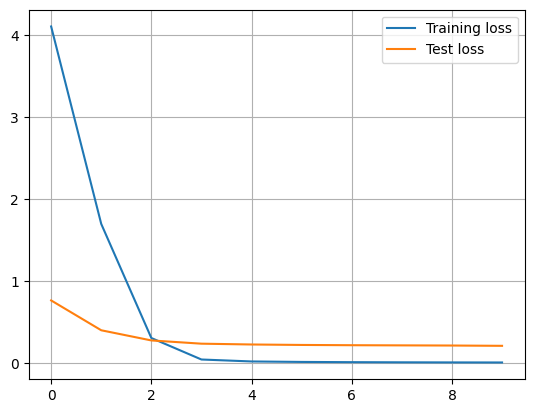

In [82]:
print(type(train_lossesV3), type(test_lossesV3))
plt.plot(train_lossesV3, label="Training loss")
plt.plot(test_lossesV3, label="Test loss")
plt.legend()
plt.grid()

Now i want create function which make predictions from our model. It puts images in model without gradient and give probabilities of every label

In [84]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    modelV3.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

Now take 9 random images from test data and put it in 2 lists

In [102]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({names[le.inverse_transform([test_labels[0]])[0]]})")

Test sample image shape: torch.Size([3, 250, 250])
Test sample label: 107 (Muhammad_Ali)


Now put that list to our make prediction function and print first prediction probabilities list

In [103]:
# Make predictions on test samples with model 2
pred_probs = make_predictions(model=modelV3,
                              data=test_samples)

# View first prediction probabilities list
pred_probs[:1]

tensor([[1.1598e-05, 1.5609e-06, 1.0532e-05, 3.7280e-07, 4.8580e-07, 2.4566e-06,
         9.8493e-08, 3.3738e-06, 1.6864e-06, 1.3914e-07, 3.8054e-07, 5.6957e-07,
         9.2481e-07, 4.5167e-06, 7.4687e-08, 7.1907e-06, 5.6672e-07, 1.6462e-06,
         1.6929e-08, 2.0256e-07, 1.8910e-06, 6.1549e-06, 3.7360e-06, 4.3725e-06,
         2.9384e-05, 5.5994e-07, 4.4207e-07, 1.4070e-07, 1.0982e-06, 3.2938e-07,
         3.9435e-07, 8.1613e-06, 1.0084e-07, 6.4928e-07, 6.3329e-06, 1.2061e-06,
         5.5873e-06, 3.8612e-06, 3.0732e-06, 6.4126e-07, 6.5353e-08, 4.8735e-06,
         1.3502e-05, 5.4130e-06, 5.0851e-08, 6.2194e-06, 2.4920e-07, 8.8716e-07,
         1.4251e-06, 1.5791e-05, 4.5637e-06, 7.1822e-07, 1.7978e-06, 1.8360e-05,
         4.5047e-07, 6.3516e-07, 3.0755e-06, 3.6240e-06, 9.0329e-07, 6.3297e-07,
         3.4656e-06, 9.0187e-07, 6.5677e-08, 4.1650e-06, 4.3433e-07, 5.5425e-07,
         4.1978e-06, 1.9096e-06, 8.9567e-07, 3.4563e-06, 1.9155e-05, 6.4585e-07,
         1.0379e-06, 1.4139e

Turn the prediction probabilities into prediction labells by taking the argmax()

In [104]:

pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([107,  91,  63,  32,  13,  54,  15,  71, 113])

Now plot all 9 images with title of name that our model predicted and the real name.

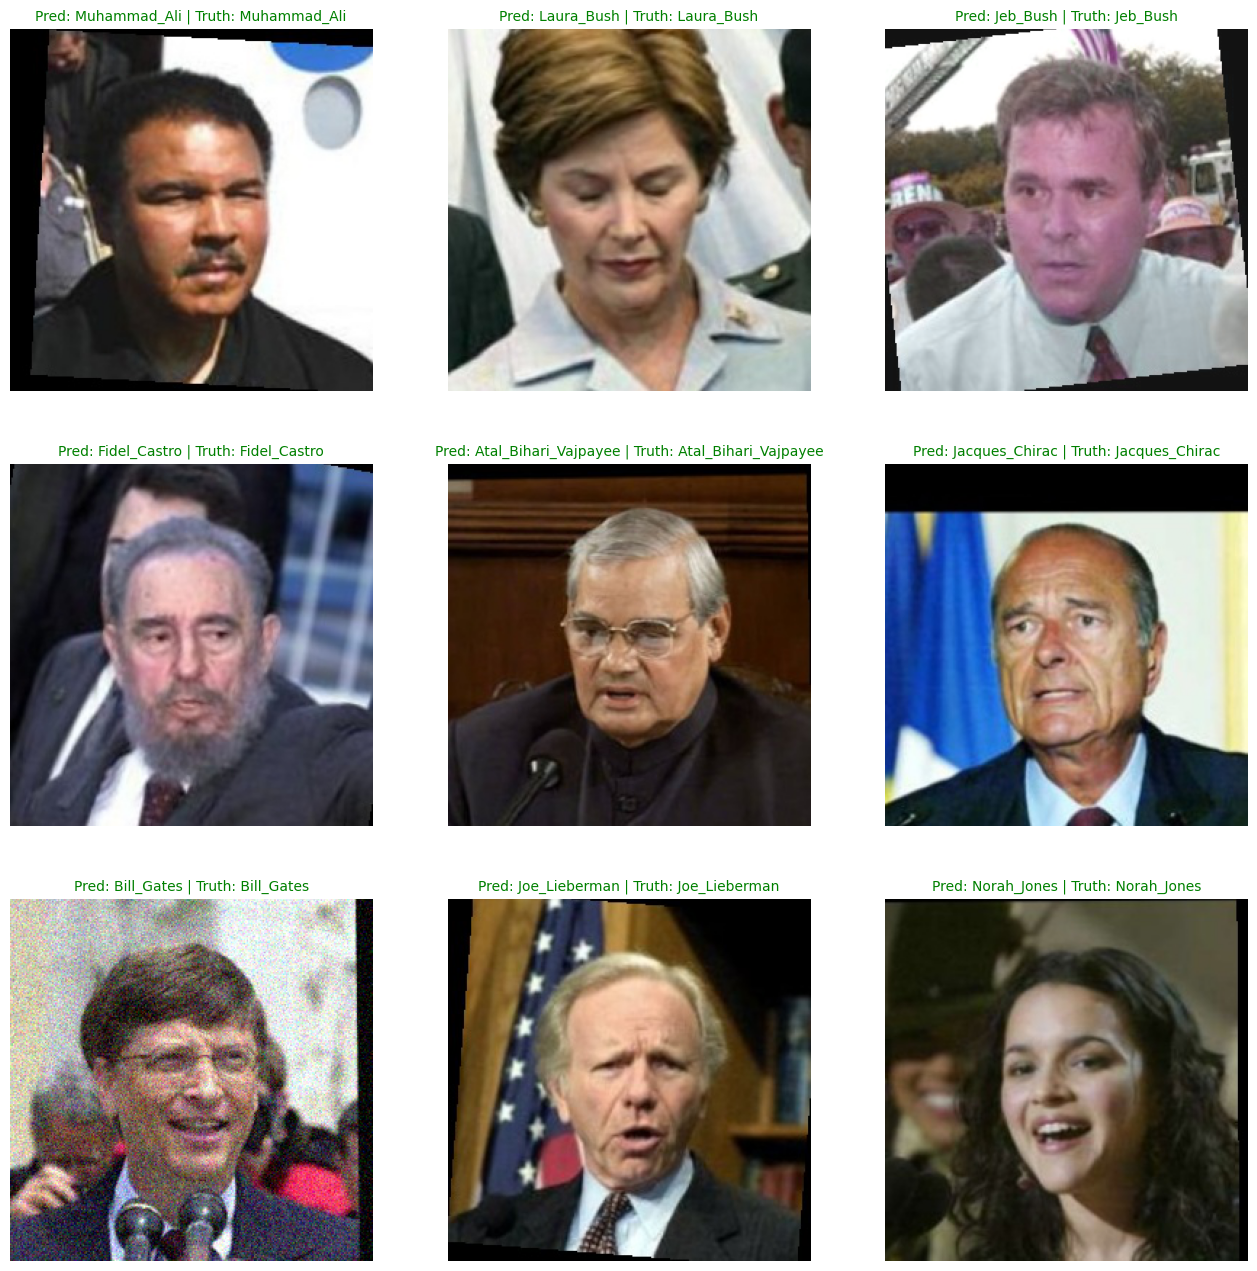

In [105]:
# Plot predictions
plt.figure(figsize=(16,16))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0))

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = names[le.inverse_transform([pred_classes[i]])[0]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = names[le.inverse_transform([test_labels[i]])[0]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

Let's modify modelV3 to get more better accuracy, i write what i try and what helps here:
Try:
Change batch size, learning rate, optimizer, regulation
Actualy help:
Model starts get more accuracy only when i add some dropout and one more convolution layer. It will let model training longer and get better result.


In [89]:
class ModifyDeepID(nn.Module):
    def __init__(self):
        super(ModifyDeepID, self).__init__()

                # First convolutional block
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3, stride=1, padding=1) #[250]
        self.bn1 = nn.BatchNorm2d(20)
        self.rel1 = nn.ReLU(inplace=True)
        self.conv12 = nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=1) #[250]
        self.bn12 = nn.BatchNorm2d(20)
        self.rel12 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)#[125]

        # Second convolutional block
        self.conv2 = nn.Conv2d(20, 40, kernel_size=4, stride=1, padding=0)#[122]
        self.bn2 = nn.BatchNorm2d(40)
        self.rel2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)#[61]
        

        # Third convolutional block
        self.conv3 = nn.Conv2d(40, 60, kernel_size=4, stride=1, padding=0)#[58]
        self.bn3 = nn.BatchNorm2d(60)
        self.rel3 = nn.ReLU(inplace=True)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)#[29]
        self.dropout3 = nn.Dropout(p=0.2)

        #four conv block
        self.conv44 = nn.Conv2d(60, 80, kernel_size=4, stride=1, padding=0)#[26]
        self.bn44 = nn.BatchNorm2d(80)
        self.rel44 = nn.ReLU()
        self.pool44 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout44 = nn.Dropout(p=0.2)



    

        # Fully connected layers
        self.fc4 = nn.Linear(80 * 13 * 13, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.rel4 = nn.ReLU(inplace=True)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(1024, out_features=len(set(new_dataset.labels)))

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rel1(x)
        x = self.conv12(x)
        x = self.bn12(x)
        x = self.rel12(x)
        x = self.pool1(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rel2(x)
        x = self.pool2(x)
        #x = self.dropout22(x)

        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.rel3(x)
        
        x = self.pool3(x)
        x = self.dropout3(x)

        #four
        x = self.conv44(x)
        x = self.bn44(x)
        x = self.rel44(x)
        x = self.pool44(x)
        x = self.dropout44(x)



        # Flatten the output from convolutional blocks
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.rel4(x)
        x = self.dropout4(x)
        x = self.fc5(x)

        return x

Load modify model 3 to device

In [90]:
modelV3_mod = ModifyDeepID()
modelV3_mod.to(device)
print(modelV3_mod)

ModifyDeepID(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel1): ReLU(inplace=True)
  (conv12): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel12): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 40, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(40, 60, kernel_size=(4, 4), stride=(1, 1))
  (bn3): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

Setup optimizer and criterion

In [91]:
optimizer = torch.optim.Adam(modelV3_mod.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

Train modify model 3. In training i test a lot of time and best what i can get with this setup was 0.92 so i make condition that if accuracy reach 92 procent break training.

In [95]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_3_mod = timer()

epochs = 120 # The total number of iterations

train_lossesV3_mod = []
test_lossesV3_mod = []

for epoch in range(epochs):
  # model for training
  modelV3_mod.train()
  train_loss = 0

  for idx, (images, labels) in enumerate(train_dataloader):

    # Send these >>> To GPU
    images = images.to(device)
    labels = labels.to(device)

    # Training pass
    optimizer.zero_grad()

    # Forward pass
    output = modelV3_mod(images)
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    if accuracy/len(test_dataloader) >= 0.92:
      break

  # model for evaluation
  modelV3_mod.eval()
  test_loss = 0
  accuracy = 0

  # Turn off gradients when performing evaluation.
  # As if we don't turn it off, we will comprise our network's weight entirely
  with torch.no_grad():
    for images, labels in test_dataloader:

      images = images.to(device)
      labels = labels.to(device) 

      log_probabilities = modelV3_mod(images)
      test_loss += criterion(log_probabilities, labels).item()

      probabilities = torch.exp(log_probabilities)
      top_prob, top_class = probabilities.topk(1, dim=1)
      predictions = top_class == labels.view(*top_class.shape)
      accuracy += torch.mean(predictions.type(torch.FloatTensor))

    train_lossesV3_mod.append(train_loss/len(train_dataloader))
    test_lossesV3_mod.append(test_loss/len(train_dataloader))

    print("Epoch: {}/{}   ".format(epoch+1, epochs),
          "Training loss: {:.4f}   ".format(train_loss/len(train_dataloader)),
          "Testing loss: {:.4f}   ".format(test_loss/len(train_dataloader)),
          "Test accuracy: {:.4f}   ".format(accuracy/len(test_dataloader)))

  if accuracy/len(test_dataloader) >= 0.92:
    break

train_time_end_model_3_mod = timer()
total_train_time_model_3_mod = print_train_time(start=train_time_start_model_3_mod,
                                               end=train_time_end_model_3_mod,
                                               device=device)

Epoch: 1/120    Training loss: 3.4015    Testing loss: 0.5845    Test accuracy: 0.4970   
Epoch: 2/120    Training loss: 1.3032    Testing loss: 0.2702    Test accuracy: 0.7810   
Epoch: 3/120    Training loss: 0.4480    Testing loss: 0.1787    Test accuracy: 0.8542   
Epoch: 4/120    Training loss: 0.1460    Testing loss: 0.1483    Test accuracy: 0.8657   
Epoch: 5/120    Training loss: 0.0654    Testing loss: 0.1338    Test accuracy: 0.8756   
Epoch: 6/120    Training loss: 0.0359    Testing loss: 0.1179    Test accuracy: 0.8908   
Epoch: 7/120    Training loss: 0.0251    Testing loss: 0.1176    Test accuracy: 0.8916   
Epoch: 8/120    Training loss: 0.0174    Testing loss: 0.1152    Test accuracy: 0.8954   
Epoch: 9/120    Training loss: 0.0154    Testing loss: 0.1116    Test accuracy: 0.8931   
Epoch: 10/120    Training loss: 0.0109    Testing loss: 0.1085    Test accuracy: 0.8992   
Epoch: 11/120    Training loss: 0.0093    Testing loss: 0.1111    Test accuracy: 0.8978   
Epoch: 1

Calculate modify model 3 results

In [96]:

model_3_mod_results = eval_model(model=modelV3_mod, data_loader=test_dataloader,
    device=device
)
model_3_mod_results

{'model_name': 'ModifyDeepID',
 'model_loss': 0.3391307989680549,
 'model_acc': tensor(0.9205)}

Plot modify model 3 training

<class 'list'> <class 'list'>


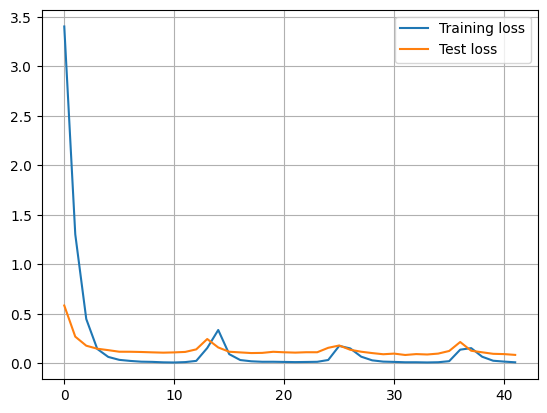

In [97]:
print(type(train_lossesV3_mod), type(test_lossesV3_mod))
plt.plot(train_lossesV3_mod, label="Training loss")
plt.plot(test_lossesV3_mod, label="Test loss")
plt.legend()
plt.grid()

Take 9 random images from test data and put it in 2 lists

In [98]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({names[le.inverse_transform([test_labels[0]])[0]]})")

Test sample image shape: torch.Size([3, 250, 250])
Test sample label: 107 (Muhammad_Ali)


Make predictions on test samples with modify model 3

In [106]:

pred_probs = make_predictions(model=modelV3_mod,
                              data=test_samples)

# View first  prediction probabilities list
pred_probs[:1]

tensor([[9.1221e-08, 1.4123e-10, 7.5939e-09, 1.0846e-10, 1.9947e-10, 2.4693e-10,
         1.6035e-11, 5.1771e-08, 5.5466e-10, 1.5875e-10, 6.8631e-11, 1.5622e-11,
         9.8391e-09, 2.1063e-10, 1.7842e-11, 9.2044e-09, 1.0839e-11, 2.8069e-11,
         3.4825e-10, 1.7871e-09, 7.2957e-10, 1.2319e-06, 7.8812e-08, 7.0773e-10,
         2.0275e-06, 4.8308e-09, 4.5377e-09, 3.7517e-13, 1.5332e-09, 3.1892e-10,
         3.8682e-11, 9.7144e-10, 7.5611e-10, 5.7622e-10, 1.8569e-10, 2.1732e-12,
         1.5025e-09, 4.4292e-09, 1.7975e-12, 5.4153e-11, 2.1493e-10, 6.9229e-10,
         1.0736e-07, 1.0969e-07, 5.5663e-11, 6.7891e-09, 3.9899e-12, 5.6118e-10,
         4.1264e-11, 8.7155e-10, 3.1740e-09, 1.7900e-10, 8.2342e-10, 2.7295e-09,
         1.5182e-09, 2.1412e-09, 2.7884e-09, 5.2501e-09, 9.6869e-08, 3.3899e-11,
         1.5178e-10, 3.9830e-11, 4.4653e-12, 1.4525e-10, 2.8331e-12, 1.5948e-09,
         1.6474e-09, 2.6806e-09, 4.0093e-11, 2.9213e-09, 6.9037e-10, 1.6542e-09,
         1.6457e-09, 8.7776e

Turn the prediction probabilities into prediction labells by taking the argmax()

In [100]:

pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([107,  91,  63,  32,  13,  54,  15,  71, 113])

Plot predictions

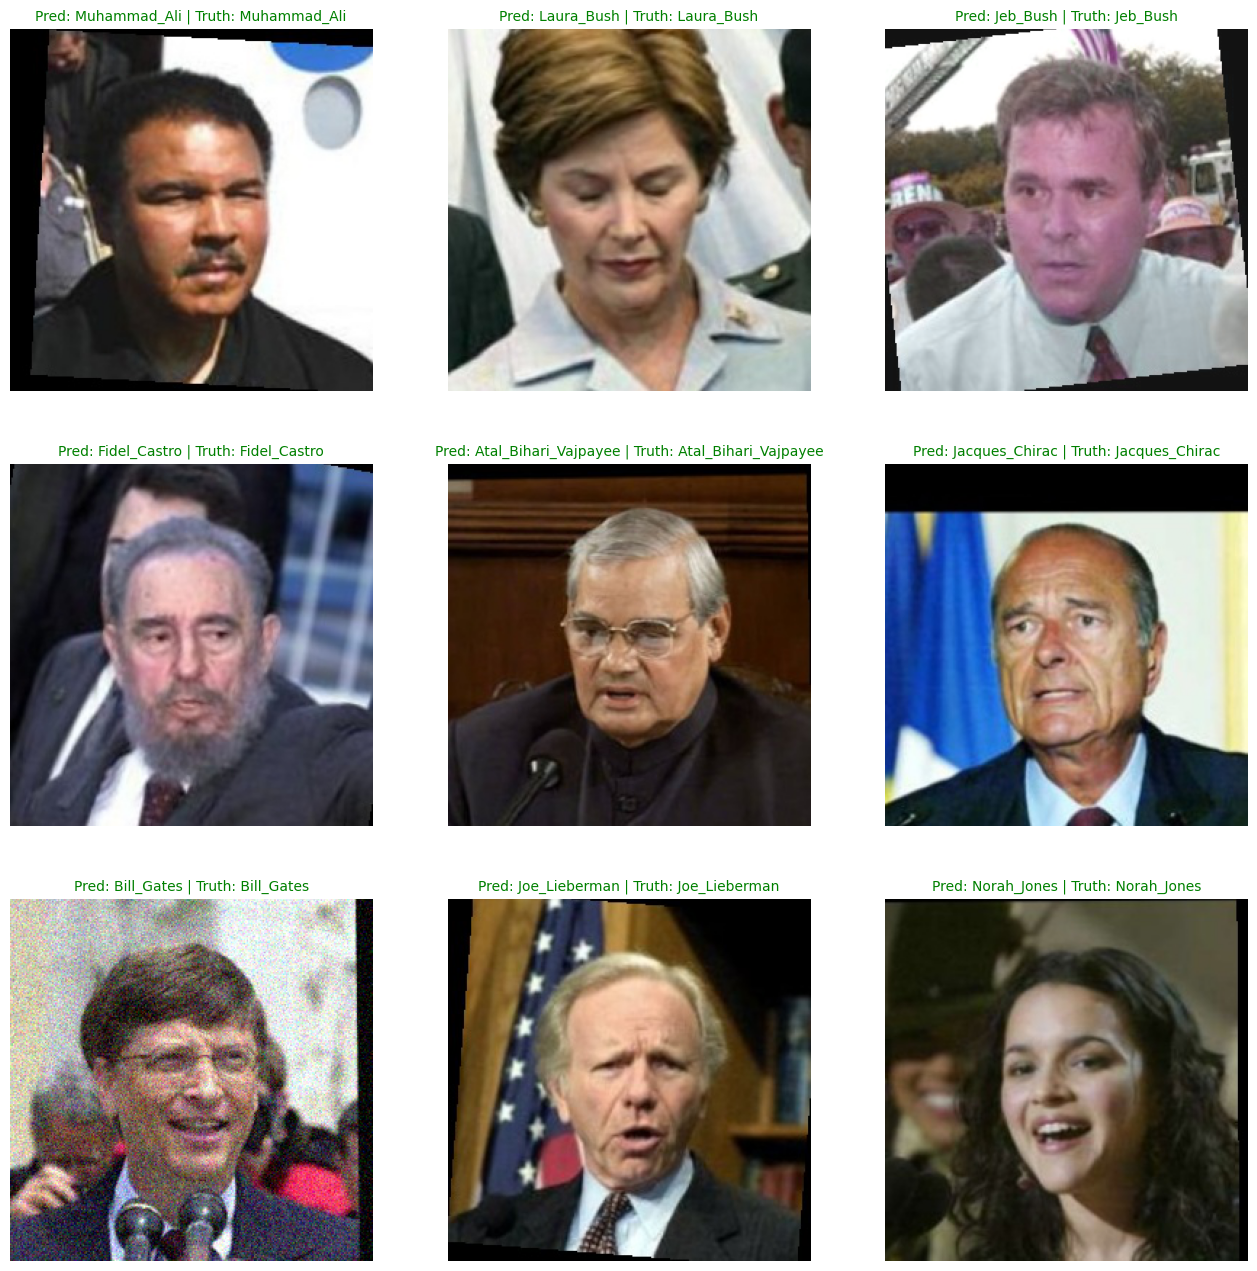

In [101]:

plt.figure(figsize=(16,16))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0))

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = names[le.inverse_transform([pred_classes[i]])[0]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = names[le.inverse_transform([test_labels[i]])[0]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

##Save model

In [108]:
# Create model save path
MODEL_NAME = "ModifyModelV3.pth"


print(f"Saving model to: {MODEL_NAME}")
torch.save(obj=modelV3_mod.state_dict(),
            f=MODEL_NAME)

Saving model to: ModifyModelV3.pth
